## Bipartite Epidemiological Monte Carlo

### Origination of Epidemiological Graph Models

Grassberger, On the Critical Behavior of the General Epidemic Process and Dynamical Percolation<br>
<br>
Where:<br>
Susceptible = S<br>
Infected = I<br>
Recovered = R<br>
The process is markoffian and infects nearest neighbors with rate sigma:

$ S(n)+I(m)\rightarrow\sigma\rightarrow I(n)+I(m)$<br>
where (n,m) are nearest neighbors, and recovery rate rho:<br>
$I(n)\rightarrow\rho\rightarrow R(n)$<br>
<br>
If rho is fixed and the length of an epidemic depends on the ratio $\sigma/\rho$ then there is some critical value $\sigma_c$ for which an epidemic may be infinite, $\sigma>\sigma_c$, with probability $0<P(\sigma)<1$, or impossible, $\sigma>\sigma_c$. $P(\sigma)$ is merely the probability that the original infected sight belongs to an infinite cluster.

### Model Details and Purpose

I am using the notation:<br>
$tao =$ infection length<br>
$tr =$ transmissibility<br>

The purpose of this notebook is to create a method to simulate the spread of an epidemic across a network that as closely as possible simulates a specific County. 

### Data Sources and Assumptions

Population by county:<br>
https://data.ers.usda.gov/reports.aspx?ID=17827
    
Age distribution by county:<br>
https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html

Employers by county:<br>
https://www.census.gov/quickfacts/fact/table/hancockcountymississippi/INC110218
https://www.census.gov/quickfacts/fact/table/jacksoncountymississippi,MS/POP645218

Initial Runs with sample data were fine, but running with inputs proportional to a true county showed a significant portion of nodes were isolated. This was due to missing links from visiting retail and entertainment locations. This data was only available at the state level; the state proportion of businesses which are B2C was used at the county level. Data sourced from:<br>
https://www.census.gov/data/tables/2017/econ/susb/2017-susb-annual.html<br>


The categories for establishments used for social settings are:<br>
Retail Trade<br>
Real Estate and Rental and Leasing<br>
Health Care and Social Assistance<br>
Arts, Entertainment, and Recreation<br>
Accommodation and Food Services<br>

Going forward, these will be aggregated under the term 'retail'. No difference in behaviors among types of establishments is built into the model. The method is randomly selecting a quantity of employment establishments equal to the state proportion of retail establishments to total employers, then using a poisson distribution with Mean 3 for the number visited by each individual; Mean 3 is an assumption chosen merely for consistency in testing and has no basis in data.

## Model Algorithm Descriptions

#### Propogation
For each node $i$ in 'Infected':<br>
&nbsp;&nbsp;&nbsp;&nbsp; For each edge $a_{ij}$ where neighbor $j$ is in 'Susceptible':<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Infect with probability 'Transmissibility' (Tr Parameter)

#### Monte Carlo of propagate
Execute propagate $n$ times<br>
Report final counts of $S$, $I$, and $R$<br>
Report Mean Lenght of Time to $I=0$<br>
Report $R/(S+R)$<br>

Modified Monte Carlo:
Report mean infection counts by day

#### Create Graph
See Bipartite Graph Example notebook

#### Social Distancing Pruning
For each link $a_{i,j}$ in lists Work, School, Retail:<br>
&nbsp;&nbsp;&nbsp;&nbsp;Remove link with Probability $sd$

#### Mean Infection Curves
For each Tr in range (min,max,step):<br>
&nbsp;&nbsp;&nbsp;&nbsp;Execute modified Monte Carlo
Plot Results

#### Mean Infection with Social Distancing
For fixed Tr found in Mean Infection Curves,<br>
And each $sd$ in range (min,max,step):<br>
&nbsp;&nbsp;&nbsp;&nbsp;Execute modified Monte Carlo<br>
Plot Results

### Library Imports

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stat
import networkx as nx
import statistics
import random
import copy
import math

### Propagation Algorithm

In [1]:
def propagation(G,tao,tr):
    # Set up data structures
    susceptible = list(G.nodes())
    infected = {}
    recovered = []
    patient0 = random.choice(susceptible)
    susceptible.remove(patient0)
    infected[patient0] = tao
    history = {'s':[len(susceptible)],'i':[1],'r':[0]}
    
    # propagate Algorithm
    while len(infected) > 0:
        recover = []
        
        # Create new infections
        for i in list(infected.keys()):
            neighbors = list(G.neighbors(i))
            for j in neighbors :
                if j in susceptible:
                    if random.random()<tr:
                        susceptible.remove(j)
                        infected[j] = tao
            # Detect Recoveries
            infected[i] -=1
            if infected[i] <1:
                recover.append(i)
        
        # Clean up recoveries
        for i in recover:
            del infected[i]
            recovered.append(i)
        
        # Store current counts
        history['s'].append(len(susceptible))
        history['i'].append(len(infected))
        history['r'].append(len(recovered))
    
    return(history)

#history = propagate(G,tao,tr)
#plt.plot(history['s'])
#plt.plot(history['i'])
#plt.plot(history['r'])

### Propagate Monte Carlo

In [34]:
def mc_perc(G,tao,tr,n):
    
    # Data Structures for results
    ratio_r_sr = []
    lengths = []
    max_infections = []
    r_hist = []

    # Call Propagation function repeatedly and store results
    for i in range(n):
        history = propagate(G,tao,tr)

        s = history['s'][-1]
        r = history['r'][-1]
        r_sr = r/(s+r)
        r_hist.append(r)
        if r_sr > 0.02:
            ratio_r_sr.append(r/(s+r))
            lengths.append(len(history['s']))
            max_infections.append(max(history['i']))

    # Print outputs
    print('Mean R:',statistics.mean(r_hist))
    print('St.D. R:',statistics.stdev(r_hist))
    
    print('Mean R/(S+R):',statistics.mean(ratio_r_sr))
    print('Ratio of R/(S+R)')
    plt.plot(ratio_r_sr)
    plt.show()
    print('Mean Max Simultaneous Infections:',statistics.mean(max_infections))
    print('St.D. Max Simultaneous Infections:',statistics.stdev(max_infections))
    print('Max # of Simultaneous Infections')
    plt.plot(max_infections)
    plt.show()
    print('Mean Length of Time:',statistics.mean(lengths))
    print('St.D. Length of Time:',statistics.stdev(lengths))
    print('Length of Time')
    plt.plot(lengths)
    plt.show()


#mc_perc(G,tao,tr,100)

### Expected Population by Location Dictionaries

In [5]:
def create_expected(start,end,mean,pop):
    counter = 0
    e_dict = {}
    for i in range(start,end):
        rand = stat.poisson.rvs(mean)
        if rand > 0:
            e_dict[i] = rand
            counter += rand
    nodes = list(e_dict.keys())
    while counter < pop:
        e_dict[random.choice(nodes)] += 1
        counter += 1
    while counter > pop:
        rand = random.choice(nodes)
        if e_dict[rand] > 1:
            e_dict[rand] -= 1
        else:
            del e_dict[rand]
            del nodes[nodes.index(rand)]
        counter -= 1
    return(e_dict)

### Graph Creation

In [2]:
def create_graph(tr,tao,n,hh,er,emp,ret,sch,age_dist):
    
    # Create data structures and variables for later use
    age_list = sorted(list(age_dist.values()))
    home_edges   = []
    school_edges = []
    work_edges   = []
    work_nodes   = {}
    retail_edges = []
    mean_home_size = n/hh
    mean_work_size = age_dist['w'] * (n*emp) / er 
    mean_school_size = age_dist['sch'] * n / sch
    people_dict = {}
    age_counts = {}
    G = nx.Graph()

    # Create Population dictionary with ages attributed
    for i in range(n):
        people_dict[i] = {}
        r_age = random.random()
        for j in range(len(age_list)):
            if r_age <= age_list[j]:
                people_dict[i]['Age'] = j
                break
    for k,v in people_dict.items():
        if v['Age'] in age_counts:
            age_counts[v['Age']] += 1
        else:
            age_counts[v['Age']]  = 1

    # Create dictionaries for Locations with expected populations
    home_dict   = create_expected(n,
                                  hh+n,
                                  mean_home_size,
                                  n)

    school_dict = create_expected(hh+n,
                                  hh+n+sch,
                                  mean_school_size,
                                  age_counts[1])

    work_dict   = create_expected(hh+n+sch,
                                  hh+n+sch+er,
                                  mean_work_size,
                                  age_counts[2]*emp)

    # Create lists of individuals with possible connections to locations
    homes, jobs, schools = [],[],[]

    for k,v in home_dict.items():
        homes = homes + [k]*v
    for k,v in school_dict.items():
        schools = schools + [k]*v
    for k,v in work_dict.items():
        jobs = jobs + [k]*v
    
    # Shuffle population-by-location lists
    random.shuffle(homes)
    random.shuffle(jobs)
    random.shuffle(schools)

    # From work locations, create retail location list
    retail_locs = []
    for i in list(work_dict.keys()):
        if random.random()<ret:
            retail_locs.append(i)

    # Attribute locations to individuals in Population dictionary
    for k,v in people_dict.items():
        if v['Age'] == 1:
            v['School'] = schools.pop()
        else:
            v['School'] = -1
        if v['Age'] == 2 and random.random()<emp and len(jobs)>0:
            v['Work'] = jobs.pop()
        else:
            v['Work'] = -1
        v['Home'] = homes.pop()
        
        # Custom location attribution for retail locations due to one-to-many nature
        rand = stat.poisson.rvs(3)
        if rand<1:
            rand=1
        elif rand>len(retail_locs):
            rand=len(retail_locs)
        selection = random.sample(retail_locs,k=rand)
        v['Retail'] = selection

    # Convert dictionaries to lists
    school_pop = {k: [] for k in list(school_dict.keys())}
    work_pop = {k: [] for k in list(work_dict.keys())}
    home_pop = {k: [] for k in list(home_dict.keys())}
    retail_pop = {k: [] for k in retail_locs}

    # Create lists of nodes in locations
    for k,v in people_dict.items():
        if v['School'] >0:
            school_pop[v['School']].append(k)
        if v['Work'] >0:
            work_pop[v['Work']].append(k)
        if v['Home'] >0:
            home_pop[v['Home']].append(k)
        for i in v['Retail']:
            retail_pop[i].append(k)

    # Iterate through lists of nodes in locations
    # and create links probabilistically
    for k,v in home_pop.items():
        for i in range(len(v)-1):
            for j in range(len(v[i+1:])):
                G.add_edge(v[i],v[j+i])
                home_edges.append([v[i],v[j+i]])

    for k,v in school_pop.items():
        if len(v) > 15:
            r = (math.log(len(v),1.2)//1)/len(v)
        else:
            r = 1
        for i in range(len(v)-1):
            for j in range(len(v[i+1:])):
                if random.random() < r:
                    G.add_edge(v[i],v[j+i])
                    school_edges.append([v[i],v[j+i]])

    for k,v in work_pop.items():
        if len(v) > 15:
            r = (math.log(len(v),1.2)//1)/len(v)
        else:
            r = 1
        for i in range(len(v)-1):
            for j in range(len(v[i+1:])):
                if random.random() < r:
                    G.add_edge(v[i],v[i+j])
                    work_edges.append([v[i],v[i+j]])
                    if k in work_nodes:
                        work_nodes[k].append(v[i])
                        work_nodes[k].append(v[i+j])
                    else:
                        work_nodes[k] = [v[i],v[i+j]]

    # Slightly different code to attribute retail locations,
    # but same core functionality
    for k,v in work_nodes.items():
        unique = []
        [unique.append(x) for x in v if x not in unique]
        work_nodes[k] = unique

    for k,v in retail_pop.items():
        if k in work_nodes:
            total_count = len(v)+len(work_nodes[k])
        else:
            total_count = len(v)
        if total_count > 5:
            r = (math.log(total_count)//1)/total_count
        else:
            r = 1/total_count
        for i in range(len(v)-1):
            for j in range(len(v[i+1:])):
                if random.random() < r:
                    G.add_edge(v[i],v[i+j])
                    retail_edges.append([v[i],v[i+j]])
            if k in list(work_nodes.keys()):
                for j in work_nodes[k]:
                    if random.random() < r:
                        G.add_edge(v[i],j)
                        retail_edges.append([v[i],j])
    
    # return output Graph
    return(G,school_edges,work_edges,retail_edges)

### Social Distancing - Edge pruning algorithm

In [7]:
def social_distance(G,wfr,sd,sch, w_e,r_e,s_e):
    G_o = copy.deepcopy(G)
    # wfr = working from home rate
    # sd  = social distancing rate for retail
    # sch = school close rate
    
    def break_links(Graph,ls,r):
        for i in ls:
            if random.random() < r:
                if Graph.has_edge(i[0],i[1]):
                    Graph.remove_edge(i[0],i[1])
        return(Graph)
    
    G_o = break_links(G_o,w_e,wfr)
    G_o = break_links(G_o,s_e,sch)
    G_o = break_links(G_o,r_e,sd)
    
    return(G_o)

### Example with a small graph for demonstration

Edges: 890   Nodes: 99


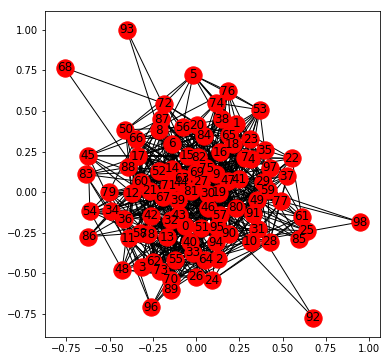

Mean R: 98.08
St.D. R: 0.7515969393123375
Mean R/(S+R): 0.9907070707070708
Ratio of R/(S+R)


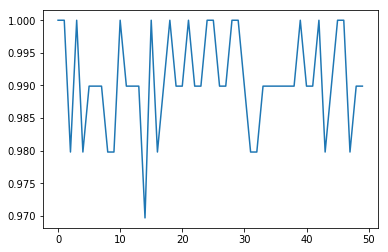

Mean Max Simultaneous Infections: 94.88
St.D. Max Simultaneous Infections: 1.709994629422286
Max # of Simultaneous Infections


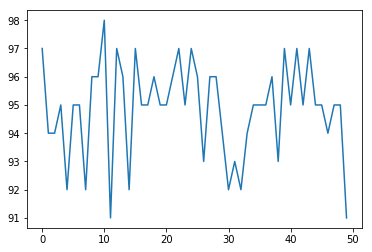

Mean Length of Time: 34.6
St.D. Length of Time: 3.557114170853924
Length of Time


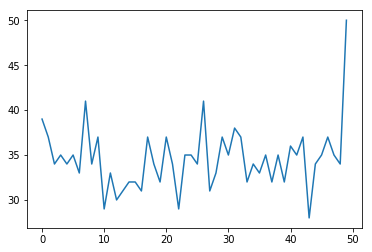




Edges: 162   Nodes: 99


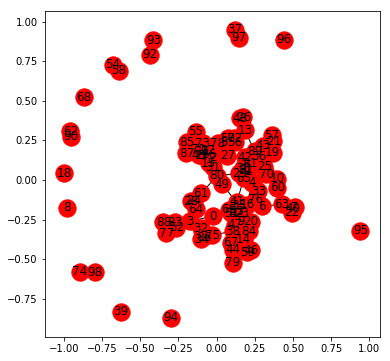

Mean R: 15.88
St.D. R: 18.44311718307324
Mean R/(S+R): 0.2132132132132132
Ratio of R/(S+R)


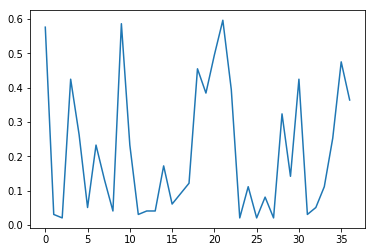

Mean Max Simultaneous Infections: 9.64864864864865
St.D. Max Simultaneous Infections: 6.468797828448911
Max # of Simultaneous Infections


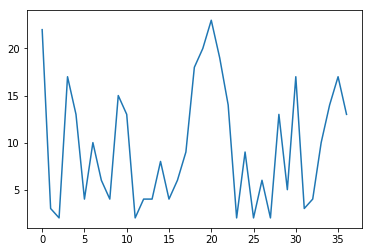

Mean Length of Time: 55.13513513513514
St.D. Length of Time: 29.346741407373177
Length of Time


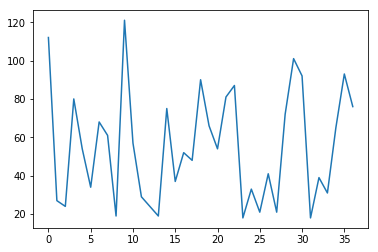

In [33]:
tr  = 0.05 # Transmissisiblity: 0 to 1
tao = 14   # Mean days I->R: 0 to Inf
n   = 100  # Population: 1 to Inf
hh  = 25   # Households: 1 to n
er  = 10   # Employers: 0 to wf 
emp = 0.95 # Rate of employment
ret = 0.6  # Number of retail locations
sch = 2    # Quantity of school #[old version] Dictionary of schools and [grades served]
age_dist = {'pk':0.05,'sch':.2,'w':.95,'r':1} # Cumulative Dictionary of age distribution

G,s_e,w_e,r_e = create_graph(tr,tao,n,hh,er,emp,ret,sch,age_dist)
print('Edges:',len(G.edges()),'  Nodes:',len(G.nodes()))
plt.figure(figsize=(6,6))
nx.draw_networkx(G)
plt.show()
mc_perc(G,tao,tr,50)

G_sd = social_distance(G,.9,.95,1,w_e,r_e,s_e) 
                     #(G,wfr,sd,sch, w_e,r_e,s_e)
print('\n\n\nEdges:',len(G_sd.edges()),'  Nodes:',len(G_sd.nodes()))
plt.figure(figsize=(6,6))
nx.draw_networkx(G_sd)
plt.show()
mc_perc(G_sd,tao,tr,50)

### Example with actual data from a County

In [24]:
# Hancock County, MS
# Divided by 10 to reduce run-times; since links of log distributions this has somewhat reduced impact
'''
tr  = 0.01            # Transmissisiblity: 0 to 1
tao = 14              # Mean days I->R: 0 to Inf
n   = 47334           # Population: 1 to Inf
hh  = 19519           # Households: 1 to n
er  = 714             # Employers: 0 to wf 
emp = 0.55            # Rate of employment
ret = (18684/44508)   # MS # Retail/Entertainment
#ret = (53288/153381) # VA
sch = 46              # Quantity of school 
age_dist = {'pk':0.0514,'sch':.2257,'w':.8671,'r':1} # Cumulative Dictionary of age distribution

G,s_e,w_e,r_e = create_graph(tr,tao,n,hh,er,emp,ret,sch,age_dist)
print('Edges:',len(G.edges()),'  Nodes:',len(G.nodes()))
mc_perc(G,tao,tr,50)

G_sd = social_distance(G,0.9,0.9,1,w_e,r_e,s_e) 
print('\n\n\nEdges:',len(G_sd.edges()),'  Nodes:',len(G_sd.nodes()))
mc_perc(G_sd,tao,tr,50)'''

### Update the MC algorithm to return the mean infections by day

In [39]:
def mc_perc_ci(G,tao,tr,n):
    
    # Data Structures for results
    ratio_r_sr = []
    lengths = []
    max_infections = []
    r_hist = []
    
    # New Variable
    collected_infections = []

    # Call propagate function repeatedly and store results
    for i in range(n):
        history = propagate(G,tao,tr)
        
        # Additional code to collect the number of infections by day
        if len(collected_infections) == 0:
            collected_infections  = history['i']
        else:
            x = len(history['i']) - len(collected_infections)
            if x > 0:
                for j in range(x):
                    collected_infections.append(0)
            for j in range(len(history['i'])):
                collected_infections[j] += history['i'][j]
                
        s = history['s'][-1]
        r = history['r'][-1]
        r_sr = r/(s+r)
        r_hist.append(r)
        if r_sr > 0.02:
            ratio_r_sr.append(r/(s+r))
            lengths.append(len(history['s']))
            max_infections.append(max(history['i']))
            
    # Average the collected data and return it
    for i in range(len(collected_infections)):
        collected_infections[i] = collected_infections[i]/n
    return(collected_infections)

### Find curves for various transmission rates

Iterating through Transmissibility
From 0.004 to 0.04


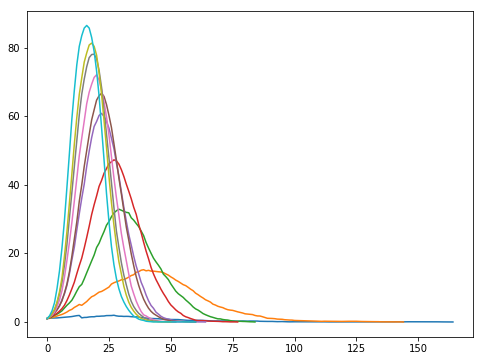

In [67]:
tr  = 0.001 # Transmissisiblity: 0 to 1
tao = 14    # Mean days I->R: 0 to Inf
n   = 100   # Population: 1 to Inf
hh  = 25    # Households: 1 to n
er  = 10    # Employers: 0 to wf 
emp = 0.95  # Rate of employment
ret = 0.6   # Number of retail locations
sch = 2     # Quantity of school 
age_dist = {'pk':0.05,'sch':.2,'w':.95,'r':1} # Cumulative Dictionary of age distribution

G,s_e,w_e,r_e = create_graph(tr,tao,n,hh,er,emp,ret,sch,age_dist)

n,x = 10,0.004
print("Iterating through Transmissibility")
print('From',x,'to',n*x)
plt.figure(figsize=(8,6))
for i in range(n):
    tr = x*(i+1)
    ci = mc_perc_ci(G,tao,tr,50)
    plt.plot(ci)

plt.show()


### Evaluate different amounts of social distancing

With Social Distancing
Edges: 104   Nodes: 99   Distance:  1.0
Edges: 179   Nodes: 99   Distance:  0.9
Edges: 269   Nodes: 99   Distance:  0.8
Edges: 314   Nodes: 99   Distance:  0.7
Edges: 396   Nodes: 99   Distance:  0.6
Edges: 504   Nodes: 99   Distance:  0.5
Edges: 572   Nodes: 99   Distance:  0.4
Edges: 631   Nodes: 99   Distance:  0.30000000000000004
Edges: 742   Nodes: 99   Distance:  0.19999999999999996
Edges: 818   Nodes: 99   Distance:  0.09999999999999998


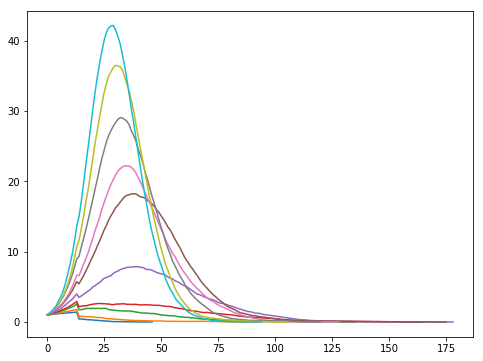

In [96]:
tr  = 0.016  # Transmissisiblity: 0 to 1
tao = 14     # Mean days I->R: 0 to Inf
n   = 100    # Population: 1 to Inf
hh  = 25     # Households: 1 to n
er  = 10     # Employers: 0 to wf 
emp = 0.95   # Rate of employment
ret = 0.6    # Number of retail locations
sch = 2      # Quantity of school 
age_dist = {'pk':0.05,'sch':.2,'w':.95,'r':1} # Cumulative Dictionary of age distribution

#print("Initial")
#G,s_e,w_e,r_e = create_graph(tr,tao,n,hh,er,emp,ret,sch,age_dist)
#ci = mc_perc_ci(G,tao,tr,200)
#plt.figure(figsize=(8,6))
#plt.plot(ci)
#plt.show()

print('With Social Distancing')
plt.figure(figsize=(8,6))
for i in range(10):
    dist = 1-(i/10)
    G_sd = social_distance(G,dist,dist,dist,w_e,r_e,s_e) 
    print('Edges:',len(G_sd.edges()),'  Nodes:',len(G_sd.nodes()),'  Distance: ',dist)
    ci = mc_perc_ci(G_sd,tao,tr,200)
    plt.plot(ci)
plt.show()

### Known Issues and Next Steps:

1) Trimming isolated nodes will clean up this graph. Graphs where the virus does not spread are not relevant to the model and create a visible error in the output.<br><br>
2) Rather than drawing a single graph, it would be better to retain the bipartite graph and allow for random infections among 'visitors' in retail, workplaces, and schools.<br><br>
3) An additional function to fit data to a gamma-family distribution is needed.<br><br>
4) A function is needed to then iterate through transmissibility parameters to match pre-quarantine rates, and a second to then fit social distancing parameters to post-quarantine rates. <br>